In [ ]:
!pip install gym numpy scipy
!pip install pyamg

# Deflation (MountainCar)

In [ ]:
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_


import gym
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spilu, cg, LinearOperator
from scipy.linalg import eigh


try:
    from pyamg import smoothed_aggregation_solver, ruge_stuben_solver
    PYAMG_AVAILABLE = True
except ImportError:
    PYAMG_AVAILABLE = False
    print("PyAMG not available. Skipping PyAMG solver.")


def timed_solver(name, solve_fn):
    start = time.time()
    theta = solve_fn()
    duration = time.time() - start
    print(f"\n{name}:\nTheta: {theta}\nTime taken: {duration:.4f} seconds")
    return theta, duration


# Compute the top-k eigenvectors of A
def get_top_k_eigenvectors(A, k):
    # eigh gives all eigenpairs of symmetric A
    eigenvalues, eigenvectors = eigh(A)
    # Sort eigenvalues descending and take top k
    idx = np.argsort(-eigenvalues)  # descending
    top_k_vecs = eigenvectors[:, idx[:k]]
    return top_k_vecs  # This is matrix P

def get_bottom_k_eigenvectors(A, k):
    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(A)
    idx = np.argsort(np.abs(eigenvalues))  # sort by smallest magnitude
    bottom_k_vecs = eigenvectors[:, idx[:k]]
    return bottom_k_vecs


def deflation_preconditioner(A, P):
    """
    Constructs the standalone deflation preconditioner B_D.

    Parameters:
        A: np.ndarray (n x n)
        P: np.ndarray (n x k) – Prolongation operator (top-k eigenvectors)

    Returns:
        B_D: np.ndarray (n x n) – Preconditioner matrix
    """
    PT = P.T
    PAP = PT @ A @ P
    inv_PAP = np.linalg.inv(PAP)
    B_D = np.eye(A.shape[0]) - A @ P @ inv_PAP @ PT
    return B_D

def solve_cg_with_deflation_preconditioner(A, b, k=2):
    # Symmetrize and regularize
    A_sym = 0.5 * (A + A.T)
    A_sym_reg = A_sym + 1e-5 * np.eye(A.shape[0])

    # Get eigenvectors from regularized symmetric matrix
    P = get_bottom_k_eigenvectors(A_sym_reg, k)
    B_D = deflation_preconditioner(A_sym_reg, P)

    # Wrap B_D as a linear operator for CG
    M = LinearOperator(A.shape, matvec=lambda x: B_D @ x)

    # Run CG
    theta, info = cg(A_sym_reg, b, M=M)

    if info != 0:
        print("CG did not fully converge. Info =", info)
    return theta


# --- Feature extraction ---
def featurize_state(state):
    """
    Map the continuous state (position, velocity) into a feature vector.
    For simplicity, we use a polynomial basis including bias, linear, quadratic, and cross terms.
    """
    pos, vel = state
    features = np.array([1.0, pos, vel, pos**2, vel**2, pos * vel])
    return features

# --- LSTD Data Collection ---
def lstd(env, num_episodes, gamma, featurize):
    """
    Run episodes under a random policy to collect data for LSTD.
    Computes:
      A = sum_t φ(s_t)[φ(s_t) - γ φ(s_{t+1})]^T,
      b = sum_t r_t φ(s_t)
    """
    # Get the feature dimension from the first state.
    n_features = len(featurize(env.reset()))
    A = np.zeros((n_features, n_features))
    b = np.zeros(n_features)

    for episode in range(num_episodes):
        s = env.reset()
        phi = featurize(s)
        done = False
        while not done:
            # Use a random policy
            a = env.action_space.sample()
            s_next, r, done, _ = env.step(a)
            # For terminal states, use a zero vector for φ(s')
            phi_next = featurize(s_next) if not done else np.zeros(n_features)
            A += np.outer(phi, (phi - gamma * phi_next))
            b += r * phi
            phi = phi_next
            s = s_next
    return A, b

# --- Policy Evaluation ---
def evaluate_policy(env, theta, featurize, gamma, num_episodes=10):
    """
    Evaluate the value function V(s) = φ(s)^T θ on a few episodes.
    For each episode, we compute the discounted return under the random policy.
    We also compute the approximated value at the initial state.
    """
    returns = []
    value_preds = []

    for _ in range(num_episodes):
        # Get prediction at the initial state
        s0 = env.reset()
        value_pred = np.dot(featurize(s0), theta)
        value_preds.append(value_pred)

        # Rollout an episode with the random policy
        s = s0
        done = False
        total_reward = 0.0
        t = 0
        while not done:
            a = env.action_space.sample()
            s, r, done, _ = env.step(a)
            total_reward += (gamma ** t) * r
            t += 1
        returns.append(total_reward)

    avg_return = np.mean(returns)
    avg_value_pred = np.mean(value_preds)
    print("Average actual return over {} episodes: {:.2f}".format(num_episodes, avg_return))
    print("Average predicted value at initial state: {:.2f}".format(avg_value_pred))
    print("difference:", abs(avg_return - avg_value_pred))
    return avg_return, avg_value_pred

# --- Main Function ---
import time  # Add this to the top of your script if not already imported

def main():
    env = gym.make('MountainCar-v0')
    gamma = 0.99
    num_data_episodes = 100  # Data collection episodes for LSTD

    print("Collecting data with LSTD...")
    A, b = lstd(env, num_data_episodes, gamma, featurize_state)

    print("\nSolving using Deflated Conjugate Gradient...")
    start = time.time()
    theta_deflated = solve_cg_with_deflation_preconditioner(A, b)
    duration_deflated = time.time() - start
    print("Theta (Deflated CG):", theta_deflated)
    print(f"Time taken (Deflated CG): {duration_deflated:.4f} seconds")

    print("\nEvaluation using Deflated CG solution:")
    evaluate_policy(env, theta_deflated, featurize_state, gamma, num_episodes=20)

    env.close()

if __name__ == '__main__':
    main()


# 1. Environment : **MountainCar**

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Solving using LU-decomposition...
Theta (LU): [-2.05823780e+00  2.62403560e+02  1.59282807e+02  2.55609004e+02
  2.83870974e+04  5.14818029e+02]
Time taken (LU): 0.0001 seconds

Solving using QR (least squares)...
Theta (QR): [-2.05823780e+00  2.62403560e+02  1.59282807e+02  2.55609004e+02
  2.83870974e+04  5.14818029e+02]
Time taken (QR): 0.0002 seconds

Solving using Conjugate Gradient with ILU preconditioner...
Theta (CG): [  -49.85754032    67.32804312  -860.91732279    65.09208997
 -1332.69321607 -1772.70115308]
Time taken (CG): 0.0019 seconds

Solving using Deflated Conjugate Gradient...
Theta (Deflated CG): [  -49.43689892    69.14716786  -818.16241314    66.75356265
   -39.29430773 -1693.38030813]
Time taken (Deflated CG): 0.0015 seconds

Solving using PyAMG...
Theta (PyAMG): [ 6.69255881e+01  5.37690157e+02 -5.12314103e+02  5.18994644e+02
  7.04410014e+04 -8.28945218e+02]
Time taken (PyAMG): 0.0018 seconds

Evaluation using PyAMG solution:


/usr/local/lib/python3.11/dist-packages/pyamg/classical/classical.py:97: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR',


Average actual return over 20 episodes: -86.60
Average predicted value at initial state: -70.43
difference: 16.173411123848453

Evaluation using LU solution:
Average actual return over 20 episodes: -86.60
Average predicted value at initial state: -68.61
difference: 17.99584417382661

Evaluation using QR solution:
Average actual return over 20 episodes: -86.60
Average predicted value at initial state: -68.56
difference: 18.0440773386931

Evaluation using CG solution:
Average actual return over 20 episodes: -86.60
Average predicted value at initial state: -67.06
difference: 19.544396140608967

Evaluation using Deflated CG solution:
Average actual return over 20 episodes: -86.60
Average predicted value at initial state: -67.15
difference: 19.447166346307725
Average actual return over 20 episodes: -86.60
Average predicted value at initial state: -68.51
difference: 18.08996525027719
Average actual return over 20 episodes: -86.60
Average predicted value at initial state: -68.37
difference: 1

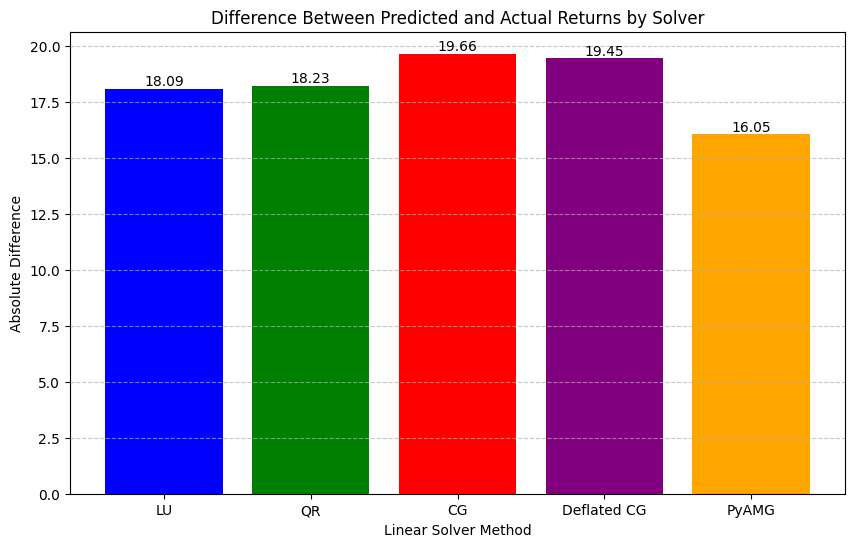

In [ ]:
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_


import gym
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spilu, cg, LinearOperator
from scipy.linalg import eigh


try:
    from pyamg import smoothed_aggregation_solver, ruge_stuben_solver
    PYAMG_AVAILABLE = True
except ImportError:
    PYAMG_AVAILABLE = False
    print("PyAMG not available. Skipping PyAMG solver.")


def timed_solver(name, solve_fn):
    start = time.time()
    theta = solve_fn()
    duration = time.time() - start
    print(f"\n{name}:\nTheta: {theta}\nTime taken: {duration:.4f} seconds")
    return theta, duration


# Compute the top-k eigenvectors of A
def get_top_k_eigenvectors(A, k):
    # eigh gives all eigenpairs of symmetric A
    eigenvalues, eigenvectors = eigh(A)
    # Sort eigenvalues descending and take top k
    idx = np.argsort(-eigenvalues)  # descending
    top_k_vecs = eigenvectors[:, idx[:k]]
    return top_k_vecs  # This is matrix P

def get_bottom_k_eigenvectors(A, k):
    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(A)
    idx = np.argsort(np.abs(eigenvalues))  # sort by smallest magnitude
    bottom_k_vecs = eigenvectors[:, idx[:k]]
    return bottom_k_vecs


def deflation_preconditioner(A, P):
    """
    Constructs the standalone deflation preconditioner B_D.

    Parameters:
        A: np.ndarray (n x n)
        P: np.ndarray (n x k) – Prolongation operator (top-k eigenvectors)

    Returns:
        B_D: np.ndarray (n x n) – Preconditioner matrix
    """
    PT = P.T
    PAP = PT @ A @ P
    inv_PAP = np.linalg.inv(PAP)
    B_D = np.eye(A.shape[0]) - A @ P @ inv_PAP @ PT
    return B_D

def solve_cg_with_deflation_preconditioner(A, b, k=2):
    # Symmetrize and regularize
    A_sym = 0.5 * (A + A.T)
    A_sym_reg = A_sym + 1e-5 * np.eye(A.shape[0])

    # Get eigenvectors from regularized symmetric matrix
    P = get_bottom_k_eigenvectors(A_sym_reg, k)
    B_D = deflation_preconditioner(A_sym_reg, P)

    # Wrap B_D as a linear operator for CG
    M = LinearOperator(A.shape, matvec=lambda x: B_D @ x)

    # Run CG
    theta, info = cg(A_sym_reg, b, M=M)

    if info != 0:
        print("CG did not fully converge. Info =", info)
    return theta


# --- Feature extraction ---
def featurize_state(state):
    """
    Map the continuous state (position, velocity) into a feature vector.
    For simplicity, we use a polynomial basis including bias, linear, quadratic, and cross terms.
    """
    pos, vel = state
    features = np.array([1.0, pos, vel, pos**2, vel**2, pos * vel])
    return features

# --- LSTD Data Collection ---
def lstd(env, num_episodes, gamma, featurize):
    """
    Run episodes under a random policy to collect data for LSTD.
    Computes:
      A = sum_t φ(s_t)[φ(s_t) - γ φ(s_{t+1})]^T,
      b = sum_t r_t φ(s_t)
    """
    # Get the feature dimension from the first state.
    n_features = len(featurize(env.reset()))
    A = np.zeros((n_features, n_features))
    b = np.zeros(n_features)

    for episode in range(num_episodes):
        s = env.reset()
        phi = featurize(s)
        done = False
        while not done:
            # Use a random policy
            a = env.action_space.sample()
            s_next, r, done, _ = env.step(a)
            # For terminal states, use a zero vector for φ(s')
            phi_next = featurize(s_next) if not done else np.zeros(n_features)
            A += np.outer(phi, (phi - gamma * phi_next))
            b += r * phi
            phi = phi_next
            s = s_next
    return A, b

# --- Linear Solvers ---
def solve_lu(A, b):
    """
    Solve Aθ = b using LU-decomposition.
    We add a small regularization term to avoid numerical issues.
    """
    reg = 1e-5 * np.eye(A.shape[0])
    theta = np.linalg.solve(A + reg, b)
    return theta

def solve_qr(A, b):
    """
    Solve Aθ = b using a QR-based least squares solution.
    """
    reg = 1e-5 * np.eye(A.shape[0])
    theta, residuals, rank, s = np.linalg.lstsq(A + reg, b, rcond=None)
    return theta

def solve_cg(A, b):
    """
    Solve Aθ = b using the conjugate gradient method with an ILU preconditioner.
    Note: CG requires a symmetric positive definite matrix. Here we symmetrize A.
    """
    # Symmetrize A
    A_sym = 0.5 * (A + A.T)
    reg = 1e-5 * np.eye(A_sym.shape[0])
    A_sym_reg = A_sym + reg
    # Convert to sparse format
    A_sparse = sparse.csc_matrix(A_sym_reg)

    # Compute an ILU preconditioner
    ilu = spilu(A_sparse)
    M = LinearOperator(A_sparse.shape, lambda x: ilu.solve(x))

    theta, info = cg(A_sparse, b, M=M)
    if info != 0:
        print("Conjugate gradient did not converge, info =", info)
    return theta

def solve_pyamg(A, b):
    """
    Solve Aθ = b using PyAMG's algebraic multigrid method.
    """
    if not PYAMG_AVAILABLE:
        raise RuntimeError("PyAMG is not installed")

    # # Symmetrize and regularize A
    # A_sym = 0.5 * (A + A.T)
    # reg = 1e-5 * np.eye(A_sym.shape[0])
    # A_sym_reg = A_sym + reg

    # # Convert to sparse format
    # A_sparse = sparse.csc_matrix(A_sym_reg)

    # # Create multigrid solver
    # ml = smoothed_aggregation_solver(A_sparse)
    ml = ruge_stuben_solver(A)
    # Solve with AMG as preconditioner for CG
    theta = ml.solve(b, tol=1e-8, accel='cg')
    return theta

# --- Policy Evaluation ---
def evaluate_policy(env, theta, featurize, gamma, num_episodes=10):
    """
    Evaluate the value function V(s) = φ(s)^T θ on a few episodes.
    For each episode, we compute the discounted return under the random policy.
    We also compute the approximated value at the initial state.
    """
    returns = []
    value_preds = []

    for _ in range(num_episodes):
        # Get prediction at the initial state
        s0 = env.reset()
        value_pred = np.dot(featurize(s0), theta)
        value_preds.append(value_pred)

        # Rollout an episode with the random policy
        s = s0
        done = False
        total_reward = 0.0
        t = 0
        while not done:
            a = env.action_space.sample()
            s, r, done, _ = env.step(a)
            total_reward += (gamma ** t) * r
            t += 1
        returns.append(total_reward)

    avg_return = np.mean(returns)
    avg_value_pred = np.mean(value_preds)
    print("Average actual return over {} episodes: {:.2f}".format(num_episodes, avg_return))
    print("Average predicted value at initial state: {:.2f}".format(avg_value_pred))
    print("difference:", abs(avg_return - avg_value_pred))
    return avg_return, avg_value_pred

# --- Main Function ---
import time  # Add this to the top of your script if not already imported

def main():
    env = gym.make('MountainCar-v0')
    gamma = 0.99
    num_data_episodes = 100  # Data collection episodes for LSTD

    print("Collecting data with LSTD...")
    A, b = lstd(env, num_data_episodes, gamma, featurize_state)

    # Solve for theta using different methods with timing
    print("\nSolving using LU-decomposition...")
    start = time.time()
    theta_lu = solve_lu(A, b)
    duration_lu = time.time() - start
    print("Theta (LU):", theta_lu)
    print(f"Time taken (LU): {duration_lu:.4f} seconds")

    print("\nSolving using QR (least squares)...")
    start = time.time()
    theta_qr = solve_qr(A, b)
    duration_qr = time.time() - start
    print("Theta (QR):", theta_qr)
    print(f"Time taken (QR): {duration_qr:.4f} seconds")

    print("\nSolving using Conjugate Gradient with ILU preconditioner...")
    start = time.time()
    theta_cg = solve_cg(A, b)
    duration_cg = time.time() - start
    print("Theta (CG):", theta_cg)
    print(f"Time taken (CG): {(time.time() - start):.4f} seconds")

    print("\nSolving using Deflated Conjugate Gradient...")
    start = time.time()
    theta_deflated = solve_cg_with_deflation_preconditioner(A, b)
    duration_deflated = time.time() - start
    print("Theta (Deflated CG):", theta_deflated)
    print(f"Time taken (Deflated CG): {duration_deflated:.4f} seconds")

    PYAMG_AVAILABLE=True
    if PYAMG_AVAILABLE:
        print("\nSolving using PyAMG...")
        try:
            start = time.time()
            theta_pyamg = solve_pyamg(A, b)
            duration_pyamg = time.time() - start
            print("Theta (PyAMG):", theta_pyamg)
            print(f"Time taken (PyAMG): {duration_pyamg:.4f} seconds")

            print("\nEvaluation using PyAMG solution:")
            evaluate_policy(env, theta_pyamg, featurize_state, gamma, num_episodes=20)
        except Exception as e:
            print(f"PyAMG solver failed: {str(e)}")
    else:
        print("\nSkipping PyAMG solver (not available)")

    # Evaluate all solutions
    print("\nEvaluation using LU solution:")
    evaluate_policy(env, theta_lu, featurize_state, gamma, num_episodes=20)

    print("\nEvaluation using QR solution:")
    evaluate_policy(env, theta_qr, featurize_state, gamma, num_episodes=20)

    print("\nEvaluation using CG solution:")
    evaluate_policy(env, theta_cg, featurize_state, gamma, num_episodes=20)

    print("\nEvaluation using Deflated CG solution:")
    evaluate_policy(env, theta_deflated, featurize_state, gamma, num_episodes=20)

    try:
        import matplotlib.pyplot as plt

        # Get evaluation results for all solvers
        solvers = ['LU', 'QR', 'CG', 'Deflated CG', 'PyAMG']
        theta_list = [theta_lu, theta_qr, theta_cg, theta_deflated]
        if PYAMG_AVAILABLE:
            theta_list.append(theta_pyamg)
        else:
            solvers = solvers[:-1]  # Remove PyAMG if not available

        # Compute differences between predicted and actual returns
        differences = []
        for theta in theta_list:
            _, avg_value_pred = evaluate_policy(env, theta, featurize_state, gamma, 20)
            # We need to recompute actual returns to ensure same random seed
            actual_returns = []
            for _ in range(20):
                s = env.reset()
                done = False
                total = 0.0
                t = 0
                while not done:
                    a = env.action_space.sample()
                    s, r, done, _ = env.step(a)
                    total += (gamma ** t) * r
                    t += 1
                actual_returns.append(total)
            avg_actual = np.mean(actual_returns)
            differences.append(abs(avg_actual - avg_value_pred))

        # Plot the differences
        plt.figure(figsize=(10, 6))
        bars = plt.bar(solvers, differences, color=['blue', 'green', 'red', 'purple', 'orange'])

        # Add values on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')

        plt.title('Difference Between Predicted and Actual Returns by Solver')
        plt.ylabel('Absolute Difference')
        plt.xlabel('Linear Solver Method')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    except ImportError:
        print("Matplotlib not available - skipping plotting")

    env.close()

if __name__ == '__main__':
    main()


# 2. Environment : **CartPole**

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Solving using LU-decomposition...
Time taken (CG): 0.0002 seconds
Theta (LU): [  19.49982001    8.13473763   -4.54533209    8.73629758   -3.20567952
  -28.66124866    1.50606819 -334.0305862    -7.72349683   32.19708178
   -5.70794846]

Solving using QR (least squares)...
Time taken (CG): 0.0003 seconds
Theta (QR): [  19.49982001    8.13473763   -4.54533209    8.73629758   -3.20567952
  -28.66124866    1.50606819 -334.0305862    -7.72349683   32.19708178
   -5.70794846]

Solving using Conjugate Gradient with ILU preconditioner...
Time taken (CG): 0.0012 seconds
Theta (CG): [  24.84788851    7.43180101    1.3243444    -1.84103275    1.01615848
  -94.28348049   47.30988892 -478.86284375   14.66935805 -166.8921295
   52.95019515]

Solving using Deflated Conjugate Gradient with ILU preconditioner...
Time taken (CG): 0.0020 seconds
Theta deflated: [  24.84788805    7.43185017    1.32444103   -1.84107641    1.01623429
  -94.28329764   47.31011311 -478.86277813   14.66946014 -166.89214377
  

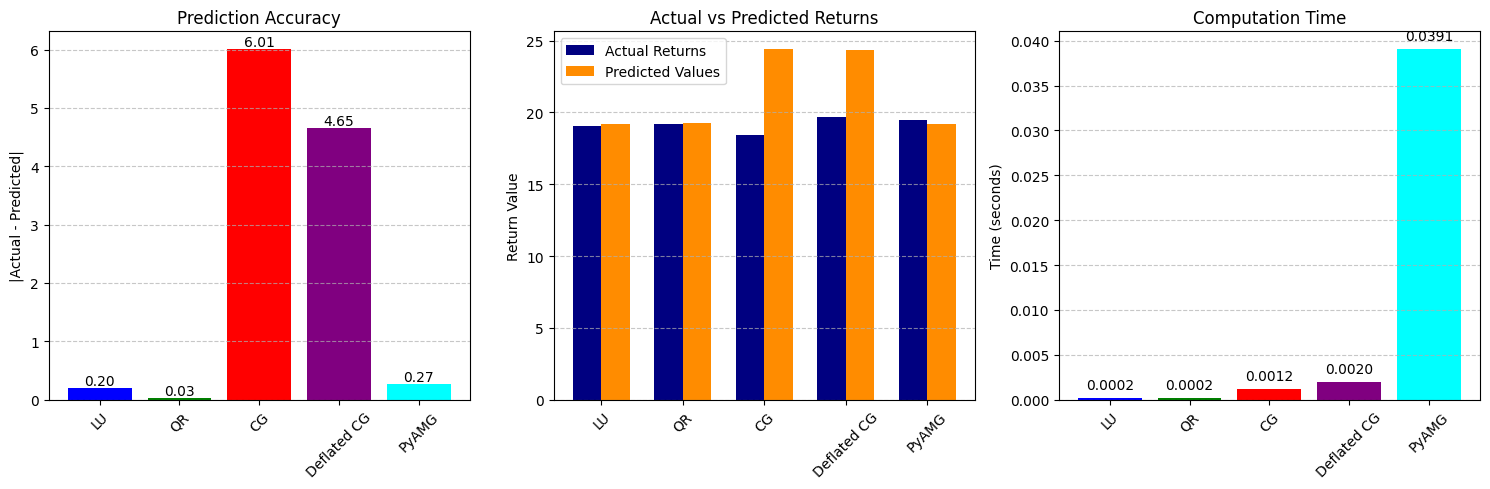

In [ ]:
  # using Cart Pole environment

import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_


import gym
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spilu, cg, LinearOperator

try:
    from pyamg import smoothed_aggregation_solver, ruge_stuben_solver
    PYAMG_AVAILABLE = True
except ImportError:
    PYAMG_AVAILABLE = False
    print("PyAMG not available. Skipping PyAMG solver.")

# Compute the top-k eigenvectors of A
def get_top_k_eigenvectors(A, k):
    # eigh gives all eigenpairs of symmetric A
    eigenvalues, eigenvectors = eigh(A)
    # Sort eigenvalues descending and take top k
    idx = np.argsort(-eigenvalues)  # descending
    top_k_vecs = eigenvectors[:, idx[:k]]
    return top_k_vecs  # This is matrix P

def get_bottom_k_eigenvectors(A, k):
    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(A)
    idx = np.argsort(np.abs(eigenvalues))  # sort by smallest magnitude
    bottom_k_vecs = eigenvectors[:, idx[:k]]
    return bottom_k_vecs


def deflation_preconditioner(A, P):
    """
    Constructs the standalone deflation preconditioner B_D.

    Parameters:
        A: np.ndarray (n x n)
        P: np.ndarray (n x k) – Prolongation operator (top-k eigenvectors)

    Returns:
        B_D: np.ndarray (n x n) – Preconditioner matrix
    """
    PT = P.T
    PAP = PT @ A @ P
    inv_PAP = np.linalg.inv(PAP)
    B_D = np.eye(A.shape[0]) - A @ P @ inv_PAP @ PT
    return B_D

def solve_cg_with_deflation_preconditioner(A, b, k=1):
    # Symmetrize and regularize
    A_sym = 0.5 * (A + A.T)
    A_sym_reg = A_sym + 1e-5 * np.eye(A.shape[0])

    # Get eigenvectors from regularized symmetric matrix
    P = get_bottom_k_eigenvectors(A_sym_reg, k)
    B_D = deflation_preconditioner(A_sym_reg, P)

    # Wrap B_D as a linear operator for CG
    M = LinearOperator(A.shape, matvec=lambda x: B_D @ x)

    # Run CG
    theta, info = cg(A_sym_reg, b, M=M)

    if info != 0:
        print("CG did not fully converge. Info =", info)
    return theta


# --- Feature extraction ---
def featurize_cartpole(state):
    # position, velocity, angular position, angular velocity
    x, x_dot, theta, theta_dot = state
    features = np.array([
        1.0,                   # bias
        x, x_dot, theta, theta_dot,
        x**2, x_dot**2, theta**2, theta_dot**2,
        x * theta, x_dot * theta_dot
    ])
    return features

# --- LSTD Data Collection ---
def lstd(env, num_episodes, gamma, featurize):
    """
    Run episodes under a random policy to collect data for LSTD.
    Computes:
      A = sum_t φ(s_t)[φ(s_t) - γ φ(s_{t+1})]^T,
      b = sum_t r_t φ(s_t)
    """
    # Get the feature dimension from the first state.
    n_features = len(featurize(env.reset()))
    A = np.zeros((n_features, n_features))
    b = np.zeros(n_features)

    for episode in range(num_episodes):
        s = env.reset()
        phi = featurize(s)
        done = False
        while not done:
            # Use a random policy
            a = env.action_space.sample()
            s_next, r, done, _ = env.step(a)
            # For terminal states, use a zero vector for φ(s')
            phi_next = featurize(s_next) if not done else np.zeros(n_features)
            A += np.outer(phi, (phi - gamma * phi_next))
            b += r * phi
            phi = phi_next
            s = s_next
    return A, b

# --- Linear Solvers ---
def solve_lu(A, b):
    """
    Solve Aθ = b using LU-decomposition.
    We add a small regularization term to avoid numerical issues.
    """
    reg = 1e-5 * np.eye(A.shape[0])
    theta = np.linalg.solve(A + reg, b)
    return theta

def solve_qr(A, b):
    """
    Solve Aθ = b using a QR-based least squares solution.
    """
    reg = 1e-5 * np.eye(A.shape[0])
    theta, residuals, rank, s = np.linalg.lstsq(A + reg, b, rcond=None)
    return theta

def solve_cg(A, b):
    """
    Solve Aθ = b using the conjugate gradient method with an ILU preconditioner.
    Note: CG requires a symmetric positive definite matrix. Here we symmetrize A.
    """
    # Symmetrize A
    A_sym = 0.5 * (A + A.T)
    reg = 1e-5 * np.eye(A_sym.shape[0])
    A_sym_reg = A_sym + reg
    # Convert to sparse format
    A_sparse = sparse.csc_matrix(A_sym_reg)

    # Compute an ILU preconditioner
    ilu = spilu(A_sparse)
    M = LinearOperator(A_sparse.shape, lambda x: ilu.solve(x))

    theta, info = cg(A_sparse, b, M=M)
    if info != 0:
        print("Conjugate gradient did not converge, info =", info)
    return theta

def solve_pyamg(A, b):
    if not PYAMG_AVAILABLE:
        raise RuntimeError("PyAMG is not installed")

    A_sparse = sparse.csr_matrix(A + 1e-5 * np.eye(A.shape[0]))  # regularize
    ml = ruge_stuben_solver(A_sparse)
    theta = ml.solve(b, tol=1e-8, accel='cg')
    return theta


# --- Policy Evaluation ---
def evaluate_policy(env, theta, featurize, gamma, num_episodes=10):
    """
    Evaluate the value function V(s) = φ(s)^T θ on a few episodes.
    For each episode, we compute the discounted return under the random policy.
    We also compute the approximated value at the initial state.
    """
    returns = []
    value_preds = []

    for _ in range(num_episodes):
        # Get prediction at the initial state
        s0 = env.reset()
        value_pred = np.dot(featurize(s0), theta)
        value_preds.append(value_pred)

        # Rollout an episode with the random policy
        s = s0
        done = False
        total_reward = 0.0
        t = 0
        while not done:
            a = env.action_space.sample()
            s, r, done, _ = env.step(a)
            total_reward += (gamma ** t) * r
            t += 1
        returns.append(total_reward)

    avg_return = np.mean(returns)
    avg_value_pred = np.mean(value_preds)
    print("Average actual return over {} episodes: {:.2f}".format(num_episodes, avg_return))
    print("Average predicted value at initial state: {:.2f}".format(avg_value_pred))
    print("difference:", abs(avg_return - avg_value_pred))
    return avg_return, avg_value_pred

# --- Main Function ---
def main():
    env = gym.make('CartPole-v1')
    gamma = 0.99
    num_data_episodes = 500  # Data collection episodes for LSTD

    print("Collecting data with LSTD...")
    A, b = lstd(env, num_data_episodes, gamma, featurize_cartpole)

    # Solve for theta using different methods
    print("\nSolving using LU-decomposition...")
    start = time.time()
    theta_lu = solve_lu(A, b)
    print(f"Time taken (CG): {(time.time() - start):.4f} seconds")
    print("Theta (LU):", theta_lu)

    print("\nSolving using QR (least squares)...")
    start = time.time()
    theta_qr = solve_qr(A, b)
    print(f"Time taken (CG): {(time.time() - start):.4f} seconds")
    print("Theta (QR):", theta_qr)

    print("\nSolving using Conjugate Gradient with ILU preconditioner...")
    start = time.time()
    theta_cg = solve_cg(A, b)
    print(f"Time taken (CG): {(time.time() - start):.4f} seconds")
    print("Theta (CG):", theta_cg)

    print("\nSolving using Deflated Conjugate Gradient with ILU preconditioner...")
    start = time.time()
    theta_deflated = solve_cg_with_deflation_preconditioner(A,b)
    print(f"Time taken (CG): {(time.time() - start):.4f} seconds")
    print("Theta deflated:", theta_deflated)

    if PYAMG_AVAILABLE:
        print("\nSolving using PyAMG...")
        try:
            start = time.time()
            theta_pyamg = solve_pyamg(A, b)
            print(f"Time taken (CG): {(time.time() - start):.4f} seconds")
            print("Theta (PyAMG):", theta_pyamg)

            print("\nEvaluation using PyAMG solution:")
            evaluate_policy(env, theta_pyamg, featurize_cartpole, gamma, num_episodes=100)
        except Exception as e:
            print(f"PyAMG solver failed: {str(e)}")
    else:
        print("\nSkipping PyAMG solver (not available)")

    # Evaluate the value function for each solution
    print("\nEvaluation using LU solution:")
    evaluate_policy(env, theta_lu, featurize_cartpole, gamma, num_episodes=100)

    print("\nEvaluation using QR solution:")
    evaluate_policy(env, theta_qr, featurize_cartpole, gamma, num_episodes=100)

    print("\nEvaluation using CG solution:")
    evaluate_policy(env, theta_cg, featurize_cartpole, gamma, num_episodes=100)

    print("\nEvaluation using deflated CG solution:")
    evaluate_policy(env, theta_deflated, featurize_cartpole, gamma, num_episodes=20)

    try:
        import matplotlib.pyplot as plt

        # Get evaluation results for all solvers
        solvers = ['LU', 'QR', 'CG', 'Deflated CG']
        theta_list = [theta_lu, theta_qr, theta_cg, theta_deflated]
        times = []

        if PYAMG_AVAILABLE:
            try:
                solvers.append('PyAMG')
                theta_list.append(theta_pyamg)
            except:
                pass

        # Compute performance metrics
        differences = []
        predictions = []
        actuals = []

        for theta in theta_list:
            actual_return, predicted_value = evaluate_policy(env, theta, featurize_cartpole, gamma, 100)
            differences.append(abs(actual_return - predicted_value))
            predictions.append(predicted_value)
            actuals.append(actual_return)

        # Create figure with 3 subplots
        plt.figure(figsize=(15, 5))

        # Plot 1: Difference between predicted and actual returns
        plt.subplot(1, 3, 1)
        bars = plt.bar(solvers, differences, color=['blue', 'green', 'red', 'purple', 'cyan'][:len(solvers)])
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}',
                    ha='center', va='bottom')
        plt.title('Prediction Accuracy')
        plt.ylabel('|Actual - Predicted|')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Plot 2: Actual vs Predicted values
        plt.subplot(1, 3, 2)
        width = 0.35
        x = np.arange(len(solvers))
        plt.bar(x - width/2, actuals, width, label='Actual Returns', color='navy')
        plt.bar(x + width/2, predictions, width, label='Predicted Values', color='darkorange')
        plt.xticks(x, solvers)
        plt.title('Actual vs Predicted Returns')
        plt.ylabel('Return Value')
        plt.legend()
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Plot 3: Time taken by each solver
        # Need to re-run timing since we want consistent measurements
        plt.subplot(1, 3, 3)
        times = []
        for solver, theta_fn in zip(solvers, [solve_lu, solve_qr, solve_cg,
                                            lambda A,b: solve_cg_with_deflation_preconditioner(A,b)]):
            start = time.time()
            theta = theta_fn(A, b)
            times.append(time.time() - start)
        if PYAMG_AVAILABLE:
            start = time.time()
            theta = solve_pyamg(A, b)
            times.append(time.time() - start)

        plt.bar(solvers, times, color=['blue', 'green', 'red', 'purple', 'cyan'][:len(solvers)])
        plt.title('Computation Time')
        plt.ylabel('Time (seconds)')
        plt.xticks(rotation=45)
        for i, v in enumerate(times):
            plt.text(i, v + 0.001, f"{v:.4f}", ha='center')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("Matplotlib not available - skipping plotting")


    env.close()

if __name__ == '__main__':
    main()




# 3. Environment : **GridWorld**


Solving using LU-decomposition...
Time taken: 0.0011 seconds
Theta (LU): [0.01373808 0.01174079 0.02167552 0.01016345 0.01629297 0.
 0.04338748 0.         0.03623916 0.09673686 0.15454801 0.
 0.         0.20784036 0.48423123 0.        ]

Solving using QR (least squares)...
Time taken: 0.0168 seconds
Theta (QR): [ 1.37380839e-02  1.17407934e-02  2.16755236e-02  1.01634546e-02
  1.62929650e-02 -8.45635632e-09  4.33874765e-02  1.79191562e-09
  3.62391595e-02  9.67368578e-02  1.54548008e-01  0.00000000e+00
  8.27180613e-25  2.07840357e-01  4.84231230e-01  0.00000000e+00]

Solving using Conjugate Gradient with ILU preconditioner...
Time taken: 0.0188 seconds
Theta (CG): [0.0039124  0.00500449 0.0112229  0.00812552 0.00656955 0.
 0.03053072 0.         0.01882632 0.06855466 0.12784392 0.
 0.         0.19154303 0.49858216 0.        ]

Solving using Deflated Conjugate Gradient...
Time taken: 0.0240 seconds
Theta (Deflated CG): [ 3.91239707e-03  5.00448655e-03  1.12228999e-02  8.12552346e-03
  

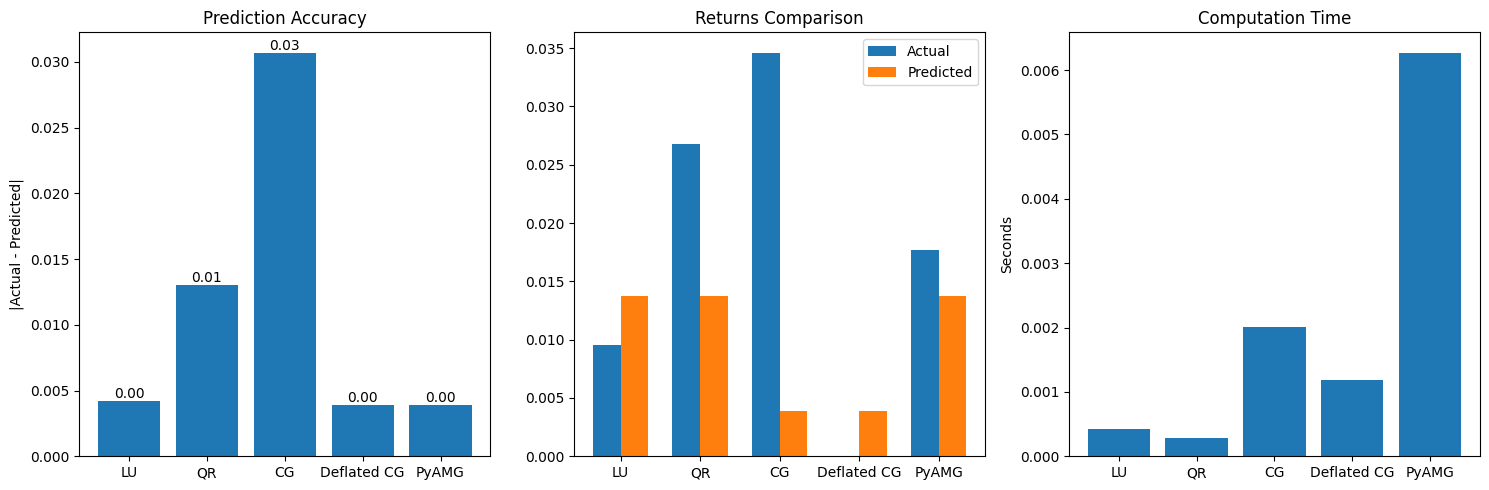

In [ ]:
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

import gym
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spilu, cg, LinearOperator
from scipy.linalg import eigh
import time

try:
    from pyamg import smoothed_aggregation_solver, ruge_stuben_solver
    PYAMG_AVAILABLE = True
except ImportError:
    PYAMG_AVAILABLE = False
    print("PyAMG not available. Skipping PyAMG solver.")

# Compute the top-k eigenvectors of A
def get_top_k_eigenvectors(A, k):
    eigenvalues, eigenvectors = eigh(A)
    idx = np.argsort(-eigenvalues)  # descending
    top_k_vecs = eigenvectors[:, idx[:k]]
    return top_k_vecs

def get_bottom_k_eigenvectors(A, k):
    eigenvalues, eigenvectors = eigh(A)
    idx = np.argsort(np.abs(eigenvalues))  # sort by smallest magnitude
    bottom_k_vecs = eigenvectors[:, idx[:k]]
    return bottom_k_vecs

def deflation_preconditioner(A, P):
    PT = P.T
    PAP = PT @ A @ P
    inv_PAP = np.linalg.inv(PAP)
    B_D = np.eye(A.shape[0]) - A @ P @ inv_PAP @ PT
    return B_D

def solve_cg_with_deflation_preconditioner(A, b, k=1):
    # Symmetrize and regularize
    A_sym = 0.5 * (A + A.T)
    A_sym_reg = A_sym + 1e-5 * np.eye(A.shape[0])

    # Get eigenvectors from regularized symmetric matrix
    P = get_bottom_k_eigenvectors(A_sym_reg, k)
    B_D = deflation_preconditioner(A_sym_reg, P)

    # Wrap B_D as a linear operator for CG
    M = LinearOperator(A.shape, matvec=lambda x: B_D @ x)

    # Run CG
    theta, info = cg(A_sym_reg, b, M=M)

    if info != 0:
        print("CG did not fully converge. Info =", info)
    return theta

# --- Feature extraction for GridWorld ---
def featurize_state_gridworld(state, env):
    n_states = env.observation_space.n
    features = np.zeros(n_states)
    features[state] = 1.0
    return features

# --- LSTD Data Collection for GridWorld ---
def lstd_gridworld(env, num_episodes, gamma, featurize):
    n_states = env.observation_space.n
    A = np.zeros((n_states, n_states))
    b = np.zeros(n_states)

    for episode in range(num_episodes):
        s = env.reset()
        phi = featurize(s, env)
        done = False
        while not done:
            a = env.action_space.sample()
            s_next, r, done, _ = env.step(a)
            phi_next = featurize(s_next, env) if not done else np.zeros(n_states)
            A += np.outer(phi, (phi - gamma * phi_next))
            b += r * phi
            phi = phi_next
            s = s_next
    return A, b

# --- Linear Solvers ---
def solve_lu(A, b):
    reg = 1e-5 * np.eye(A.shape[0])
    theta = np.linalg.solve(A + reg, b)
    return theta

def solve_qr(A, b):
    reg = 1e-5 * np.eye(A.shape[0])
    theta, residuals, rank, s = np.linalg.lstsq(A + reg, b, rcond=None)
    return theta

def solve_cg(A, b):
    A_sym = 0.5 * (A + A.T)
    reg = 1e-5 * np.eye(A_sym.shape[0])
    A_sym_reg = A_sym + reg
    A_sparse = sparse.csc_matrix(A_sym_reg)

    ilu = spilu(A_sparse)
    M = LinearOperator(A_sparse.shape, lambda x: ilu.solve(x))

    theta, info = cg(A_sparse, b, M=M)
    if info != 0:
        print("Conjugate gradient did not converge, info =", info)
    return theta

def solve_pyamg(A, b):
    if not PYAMG_AVAILABLE:
        raise RuntimeError("PyAMG is not installed")

    A_sparse = sparse.csr_matrix(A + 1e-5 * np.eye(A.shape[0]))  # regularize
    ml = ruge_stuben_solver(A_sparse)
    theta = ml.solve(b, tol=1e-8, accel='cg')
    return theta

# --- Policy Evaluation for GridWorld ---
def evaluate_policy_gridworld(env, theta, featurize, gamma, num_episodes=10):
    returns = []
    value_preds = []

    for _ in range(num_episodes):
        s0 = env.reset()
        value_pred = np.dot(featurize(s0, env), theta)
        value_preds.append(value_pred)

        s = s0
        done = False
        total_reward = 0.0
        t = 0
        while not done:
            a = env.action_space.sample()
            s, r, done, _ = env.step(a)
            total_reward += (gamma ** t) * r
            t += 1
        returns.append(total_reward)

    avg_return = np.mean(returns)
    avg_value_pred = np.mean(value_preds)
    print("Average actual return over {} episodes: {:.2f}".format(num_episodes, avg_return))
    print("Average predicted value at initial state: {:.2f}".format(avg_value_pred))
    print("difference:", abs(avg_return - avg_value_pred))
    return avg_return, avg_value_pred

# --- Main Function for GridWorld ---
def main_gridworld():
    env = gym.make('FrozenLake-v1', is_slippery=True)
    gamma = 0.99
    num_data_episodes = 10000

    print("Collecting data with LSTD...")
    A, b = lstd_gridworld(env, num_data_episodes, gamma, featurize_state_gridworld)

    # Solve for theta using different methods
    print("\nSolving using LU-decomposition...")
    start = time.time()
    theta_lu = solve_lu(A, b)
    print(f"Time taken: {(time.time() - start):.4f} seconds")
    print("Theta (LU):", theta_lu)

    print("\nSolving using QR (least squares)...")
    start = time.time()
    theta_qr = solve_qr(A, b)
    print(f"Time taken: {(time.time() - start):.4f} seconds")
    print("Theta (QR):", theta_qr)

    print("\nSolving using Conjugate Gradient with ILU preconditioner...")
    start = time.time()
    theta_cg = solve_cg(A, b)
    print(f"Time taken: {(time.time() - start):.4f} seconds")
    print("Theta (CG):", theta_cg)

    print("\nSolving using Deflated Conjugate Gradient...")
    start = time.time()
    theta_deflated = solve_cg_with_deflation_preconditioner(A, b)
    print(f"Time taken: {(time.time() - start):.4f} seconds")
    print("Theta (Deflated CG):", theta_deflated)

    if PYAMG_AVAILABLE:
        print("\nSolving using PyAMG...")
        try:
            start = time.time()
            theta_pyamg = solve_pyamg(A, b)
            print(f"Time taken: {(time.time() - start):.4f} seconds")
            print("Theta (PyAMG):", theta_pyamg)

            print("\nEvaluation using PyAMG solution:")
            evaluate_policy_gridworld(env, theta_pyamg, featurize_state_gridworld, gamma, 100)
        except Exception as e:
            print(f"PyAMG solver failed: {str(e)}")
    else:
        print("\nSkipping PyAMG solver (not available)")

    # Evaluate all solutions
    print("\nEvaluation using LU solution:")
    evaluate_policy_gridworld(env, theta_lu, featurize_state_gridworld, gamma, 100)

    print("\nEvaluation using QR solution:")
    evaluate_policy_gridworld(env, theta_qr, featurize_state_gridworld, gamma, 100)

    print("\nEvaluation using CG solution:")
    evaluate_policy_gridworld(env, theta_cg, featurize_state_gridworld, gamma, 100)

    print("\nEvaluation using Deflated CG solution:")
    evaluate_policy_gridworld(env, theta_deflated, featurize_state_gridworld, gamma, 100)

    # Visualization
    try:
        import matplotlib.pyplot as plt

        solvers = ['LU', 'QR', 'CG', 'Deflated CG']
        theta_list = [theta_lu, theta_qr, theta_cg, theta_deflated]
        if PYAMG_AVAILABLE:
            solvers.append('PyAMG')
            theta_list.append(theta_pyamg)

        # Compute metrics
        differences = []
        predictions = []
        actuals = []

        for theta in theta_list:
            actual_return, predicted_value = evaluate_policy_gridworld(env, theta, featurize_state_gridworld, gamma, 100)
            differences.append(abs(actual_return - predicted_value))
            predictions.append(predicted_value)
            actuals.append(actual_return)

        # Plotting
        plt.figure(figsize=(15, 5))

        # Difference plot
        plt.subplot(1, 3, 1)
        bars = plt.bar(solvers, differences)
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')
        plt.title('Prediction Accuracy')
        plt.ylabel('|Actual - Predicted|')

        # Actual vs Predicted
        plt.subplot(1, 3, 2)
        width = 0.35
        x = np.arange(len(solvers))
        plt.bar(x - width/2, actuals, width, label='Actual')
        plt.bar(x + width/2, predictions, width, label='Predicted')
        plt.xticks(x, solvers)
        plt.title('Returns Comparison')
        plt.legend()

        # Time plot
        plt.subplot(1, 3, 3)
        times = []
        for solver in solvers:
            start = time.time()
            if solver == 'LU':
                solve_lu(A, b)
            elif solver == 'QR':
                solve_qr(A, b)
            elif solver == 'CG':
                solve_cg(A, b)
            elif solver == 'Deflated CG':
                solve_cg_with_deflation_preconditioner(A, b)
            elif solver == 'PyAMG' and PYAMG_AVAILABLE:
                solve_pyamg(A, b)
            times.append(time.time() - start)

        plt.bar(solvers, times)
        plt.title('Computation Time')
        plt.ylabel('Seconds')

        plt.tight_layout()
        plt.show()

    except ImportError:
        print("Matplotlib not available - skipping plotting")

    env.close()

if __name__ == '__main__':
    main_gridworld()

In [ ]:
  # using Cart Pole environment

import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_


import gym
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spilu, cg, LinearOperator

from sklearn.preprocessing import PolynomialFeatures


poly = PolynomialFeatures(degree=8, include_bias=True, interaction_only=False)

try:
    from pyamg import smoothed_aggregation_solver, ruge_stuben_solver
    PYAMG_AVAILABLE = True
except ImportError:
    PYAMG_AVAILABLE = False
    print("PyAMG not available. Skipping PyAMG solver.")

# Compute the top-k eigenvectors of A
def get_top_k_eigenvectors(A, k):
    # eigh gives all eigenpairs of symmetric A
    eigenvalues, eigenvectors = eigh(A)
    # Sort eigenvalues descending and take top k
    idx = np.argsort(-eigenvalues)  # descending
    top_k_vecs = eigenvectors[:, idx[:k]]
    return top_k_vecs  # This is matrix P

def get_bottom_k_eigenvectors(A, k):
    # Get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = eigh(A)
    idx = np.argsort(np.abs(eigenvalues))  # sort by smallest magnitude
    bottom_k_vecs = eigenvectors[:, idx[:k]]
    return bottom_k_vecs


def deflation_preconditioner(A, P):
    """
    Constructs the standalone deflation preconditioner B_D.

    Parameters:
        A: np.ndarray (n x n)
        P: np.ndarray (n x k) – Prolongation operator (top-k eigenvectors)

    Returns:
        B_D: np.ndarray (n x n) – Preconditioner matrix
    """
    PT = P.T
    PAP = PT @ A @ P
    inv_PAP = np.linalg.inv(PAP)
    B_D = np.eye(A.shape[0]) - A @ P @ inv_PAP @ PT
    return B_D

def solve_cg_with_deflation_preconditioner(A, b, k=1):
    # Symmetrize and regularize
    A_sym = 0.5 * (A + A.T)
    A_sym_reg = A_sym + 1e-5 * np.eye(A.shape[0])

    # Get eigenvectors from regularized symmetric matrix
    P = get_bottom_k_eigenvectors(A_sym_reg, k)
    B_D = deflation_preconditioner(A_sym_reg, P)

    # Wrap B_D as a linear operator for CG
    M = LinearOperator(A.shape, matvec=lambda x: B_D @ x)

    # Run CG
    theta, info = cg(A_sym_reg, b, M=M)

    if info != 0:
        print("CG did not fully converge. Info =", info)
    return theta

# # --- Feature extraction ---
# def featurize_state(state):
#     # Ensure it's a 2D array: [ [pos, vel] ]
#     state = np.array(state).reshape(1, -1)
#     return poly.fit_transform(state)[0]

def featurize_cartpole(state):
    state = np.array(state).reshape(1, -1)
    return poly.fit_transform(state)[0]


# --- Feature extraction ---
# def featurize_cartpole(state):
#     # position, velocity, angular position, angular velocity
#     x, x_dot, theta, theta_dot = state
#     features = np.array([
#         1.0,                   # bias
#         x, x_dot, theta, theta_dot,
#         x**2, x_dot**2, theta**2, theta_dot**2,
#         x * theta, x_dot * theta_dot
#     ])
#     return features

# --- LSTD Data Collection ---
def lstd(env, num_episodes, gamma, featurize):
    """
    Run episodes under a random policy to collect data for LSTD.
    Computes:
      A = sum_t φ(s_t)[φ(s_t) - γ φ(s_{t+1})]^T,
      b = sum_t r_t φ(s_t)
    """
    # Get the feature dimension from the first state.
    n_features = len(featurize(env.reset()))
    A = np.zeros((n_features, n_features))
    b = np.zeros(n_features)

    for episode in range(num_episodes):
        s = env.reset()
        phi = featurize(s)
        done = False
        while not done:
            # Use a random policy
            a = env.action_space.sample()
            s_next, r, done, _ = env.step(a)
            # For terminal states, use a zero vector for φ(s')
            phi_next = featurize(s_next) if not done else np.zeros(n_features)
            A += np.outer(phi, (phi - gamma * phi_next))
            b += r * phi
            phi = phi_next
            s = s_next
    return A, b

# --- Linear Solvers ---
def solve_lu(A, b):
    """
    Solve Aθ = b using LU-decomposition.
    We add a small regularization term to avoid numerical issues.
    """
    reg = 1e-5 * np.eye(A.shape[0])
    theta = np.linalg.solve(A + reg, b)
    return theta

def solve_qr(A, b):
    """
    Solve Aθ = b using a QR-based least squares solution.
    """
    reg = 1e-5 * np.eye(A.shape[0])
    theta, residuals, rank, s = np.linalg.lstsq(A + reg, b, rcond=None)
    return theta

def solve_cg(A, b):
    """
    Solve Aθ = b using the conjugate gradient method with an ILU preconditioner.
    Note: CG requires a symmetric positive definite matrix. Here we symmetrize A.
    """
    # Symmetrize A
    A_sym = 0.5 * (A + A.T)
    reg = 1e-5 * np.eye(A_sym.shape[0])
    A_sym_reg = A_sym + reg
    # Convert to sparse format
    A_sparse = sparse.csc_matrix(A_sym_reg)

    # Compute an ILU preconditioner
    ilu = spilu(A_sparse)
    M = LinearOperator(A_sparse.shape, lambda x: ilu.solve(x))

    theta, info = cg(A_sparse, b, M=M)
    if info != 0:
        print("Conjugate gradient did not converge, info =", info)
    return theta

def solve_pyamg(A, b):
    if not PYAMG_AVAILABLE:
        raise RuntimeError("PyAMG is not installed")

    A_sparse = sparse.csr_matrix(A + 1e-5 * np.eye(A.shape[0]))  # regularize
    ml = ruge_stuben_solver(A_sparse)
    theta = ml.solve(b, tol=1e-8, accel='cg')
    return theta


# --- Policy Evaluation ---
def evaluate_policy(env, theta, featurize, gamma, num_episodes=10):
    """
    Evaluate the value function V(s) = φ(s)^T θ on a few episodes.
    For each episode, we compute the discounted return under the random policy.
    We also compute the approximated value at the initial state.
    """
    returns = []
    value_preds = []

    for _ in range(num_episodes):
        # Get prediction at the initial state
        s0 = env.reset()
        value_pred = np.dot(featurize(s0), theta)
        value_preds.append(value_pred)

        # Rollout an episode with the random policy
        s = s0
        done = False
        total_reward = 0.0
        t = 0
        while not done:
            a = env.action_space.sample()
            s, r, done, _ = env.step(a)
            total_reward += (gamma ** t) * r
            t += 1
        returns.append(total_reward)

    avg_return = np.mean(returns)
    avg_value_pred = np.mean(value_preds)
    print("Average actual return over {} episodes: {:.2f}".format(num_episodes, avg_return))
    print("Average predicted value at initial state: {:.2f}".format(avg_value_pred))
    return avg_return, avg_value_pred

# --- Main Function ---
def main():
    env = gym.make('CartPole-v1')
    gamma = 0.99
    num_data_episodes = 100  # Data collection episodes for LSTD

    print("Collecting data with LSTD...")
    A, b = lstd(env, num_data_episodes, gamma, featurize_cartpole)

    # Solve for theta using different methods
    print("\nSolving using LU-decomposition...")
    start = time.time()
    theta_lu = solve_lu(A, b)
    duration_lu = time.time() - start
    #print("Theta (LU):", theta_lu)
    print(f"Time taken (LU): {(time.time() - start):.4f} seconds")

    print("\nSolving using QR (least squares)...")
    start = time.time()
    theta_qr = solve_qr(A, b)
    #print("Theta (QR):", theta_qr)
    print(f"Time taken (QR): {(time.time() - start):.4f} seconds")

    print("\nSolving using Conjugate Gradient with ILU preconditioner...")
    start = time.time()
    theta_cg = solve_cg(A, b)
    #print("Theta (CG):", theta_cg)
    print(f"Time taken (CG): {(time.time() - start):.4f} seconds")

    print("\nSolving using Deflated Conjugate Gradient with ILU preconditioner...")
    start = time.time()
    theta_deflated = solve_cg_with_deflation_preconditioner(A,b)
    #print("Theta deflated:", theta_deflated)
    print(f"Time taken (CG deflated): {(time.time() - start):.4f} seconds")

    if PYAMG_AVAILABLE:
        print("\nSolving using PyAMG...")
        try:
            start = time.time()
            theta_pyamg = solve_pyamg(A, b)
            print(f"Time taken (CG): {(time.time() - start):.4f} seconds")
            #print("Theta (PyAMG):", theta_pyamg)

            print("\nEvaluation using PyAMG solution:")
            evaluate_policy(env, theta_pyamg, featurize_cartpole, gamma, num_episodes=100)
        except Exception as e:
            print(f"PyAMG solver failed: {str(e)}")
    else:
        print("\nSkipping PyAMG solver (not available)")

    # Evaluate the value function for each solution
    print("\nEvaluation using LU solution:")
    evaluate_policy(env, theta_lu, featurize_cartpole, gamma, num_episodes=100)

    print("\nEvaluation using QR solution:")
    evaluate_policy(env, theta_qr, featurize_cartpole, gamma, num_episodes=100)

    print("\nEvaluation using CG solution:")
    evaluate_policy(env, theta_cg, featurize_cartpole, gamma, num_episodes=100)

    print("\nEvaluation using deflated CG solution:")
    evaluate_policy(env, theta_deflated, featurize_cartpole, gamma, num_episodes=20)

    env.close()

if __name__ == '__main__':
    main()




/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Solving using LU-decomposition...
Time taken (LU): 0.0084 seconds

Solving using QR (least squares)...
Time taken (QR): 0.0545 seconds

Solving using Conjugate Gradient with ILU preconditioner...
Conjugate gradient did not converge, info = 4950
Time taken (CG): 2.8745 seconds

Solving using Deflated Conjugate Gradient with ILU preconditioner...
CG did not fully converge. Info = 4950
Time taken (CG deflated): 1.1950 seconds

Solving using PyAMG...
Time taken (CG): 0.4248 seconds

Evaluation using PyAMG solution:
Average actual return over 100 episodes: 19.90
Average predicted value at initial state: 21.38

Evaluation using LU solution:
Average actual return over 100 episodes: 18.60
Average predicted value at initial state: 21.03

Evaluation using QR solution:
Average actual return over 100 episodes: 20.60
Average predicted value at initial state: 21.21

Evaluation using CG solution:
Average actual return over 100 episodes: 17.91
Average predicted value at initial state: -0.08

Evaluati

# **4. Environment : AcroBot**

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Solving using LU-decomposition...

Solving using QR (least squares)...

Solving using Conjugate Gradient with ILU preconditioner...

Solving using Deflated Conjugate Gradient...

Solving using PyAMG...

Evaluation using LU solution:


/usr/local/lib/python3.11/dist-packages/pyamg/krylov/_cg.py:160: UserWarning: 
Indefinite preconditioner detected in CG, aborting

  warn('\nIndefinite preconditioner detected in CG, aborting\n')


Average actual return over 20 episodes: -99.34
Average predicted value at initial state: -90.35
difference: 8.99

Evaluation using QR solution:
Average actual return over 20 episodes: -99.34
Average predicted value at initial state: -90.39
difference: 8.95

Evaluation using CG solution:
Average actual return over 20 episodes: -99.34
Average predicted value at initial state: -82.21
difference: 17.14

Evaluation using Deflated CG solution:
Average actual return over 20 episodes: -99.34
Average predicted value at initial state: -82.20
difference: 17.14

Evaluation using PyAMG solution:
Average actual return over 20 episodes: -99.34
Average predicted value at initial state: -82.32
difference: 17.02


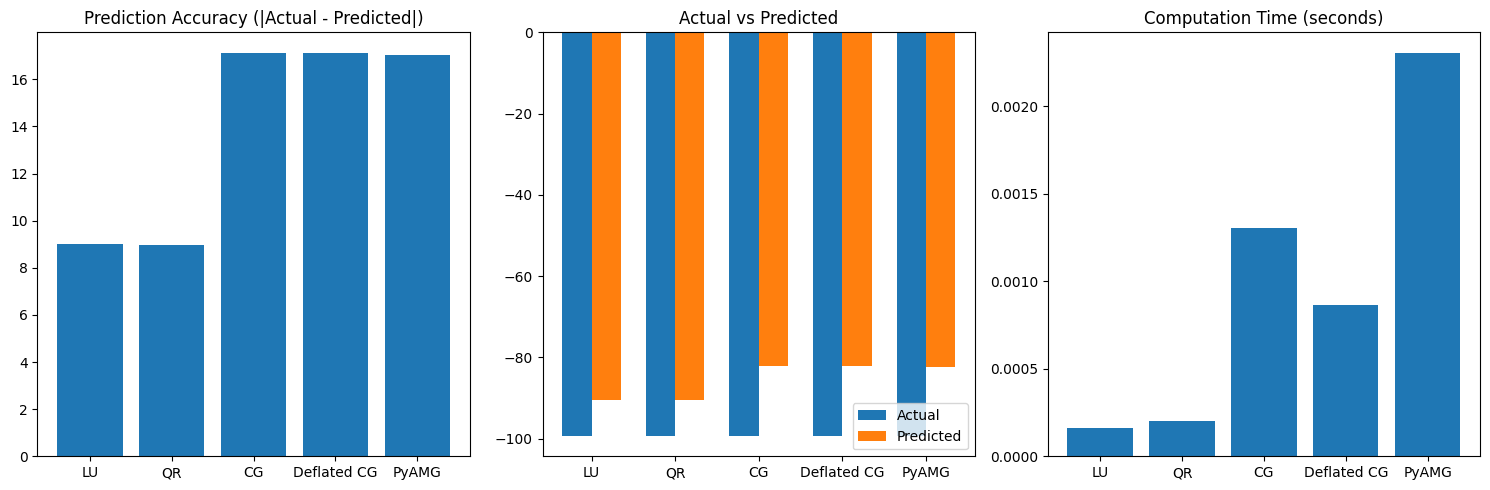

In [ ]:
# ACROBOT

import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
if not hasattr(np, 'float_'):
    np.float_ = np.float64

import gym
import time
from scipy import sparse
from scipy.sparse.linalg import spilu, cg, LinearOperator
from scipy.linalg import eigh

try:
    from pyamg import ruge_stuben_solver
    PYAMG_AVAILABLE = True
except ImportError:
    PYAMG_AVAILABLE = False
    print("PyAMG not available. Skipping PyAMG solver.")

# --- Feature extraction for Acrobot ---
def featurize_acrobot(state):
    return np.array([
        1.0,
        *state,
        state[0]*state[2], state[1]*state[3],
        state[4]*state[5],
        state[0]**2, state[1]**2, state[2]**2, state[3]**2,
        state[4]**2, state[5]**2
    ])

# --- LSTD Data Collection ---
def lstd(env, num_episodes, gamma, featurize):
    n_features = len(featurize(env.reset()))
    A = np.zeros((n_features, n_features))
    b = np.zeros(n_features)
    for _ in range(num_episodes):
        s = env.reset()
        phi = featurize(s)
        done = False
        while not done:
            a = env.action_space.sample()
            s_next, r, done, _ = env.step(a)
            phi_next = featurize(s_next) if not done else np.zeros(n_features)
            A += np.outer(phi, (phi - gamma * phi_next))
            b += r * phi
            phi = phi_next
            s = s_next
    return A, b

# --- Solvers ---
def solve_lu(A, b):
    return np.linalg.solve(A + 1e-5 * np.eye(A.shape[0]), b)

def solve_qr(A, b):
    return np.linalg.lstsq(A + 1e-5 * np.eye(A.shape[0]), b, rcond=None)[0]

def solve_cg(A, b):
    A_sym = 0.5 * (A + A.T) + 1e-5 * np.eye(A.shape[0])
    A_sparse = sparse.csc_matrix(A_sym)
    ilu = spilu(A_sparse)
    M = LinearOperator(A_sparse.shape, ilu.solve)
    theta, _ = cg(A_sparse, b, M=M)
    return theta

def get_bottom_k_eigenvectors(A, k):
    eigenvalues, eigenvectors = eigh(A)
    idx = np.argsort(np.abs(eigenvalues))
    return eigenvectors[:, idx[:k]]

def deflation_preconditioner(A, P):
    PT = P.T
    inv_PAP = np.linalg.inv(PT @ A @ P)
    return np.eye(A.shape[0]) - A @ P @ inv_PAP @ PT

def solve_cg_with_deflation_preconditioner(A, b, k=1):
    A_sym = 0.5 * (A + A.T) + 1e-5 * np.eye(A.shape[0])
    P = get_bottom_k_eigenvectors(A_sym, k)
    B_D = deflation_preconditioner(A_sym, P)
    M = LinearOperator(A.shape, matvec=lambda x: B_D @ x)
    theta, _ = cg(A_sym, b, M=M)
    return theta

def solve_pyamg(A, b):
    if not PYAMG_AVAILABLE:
        raise RuntimeError("PyAMG not installed")
    A_sparse = sparse.csr_matrix(A + 1e-5 * np.eye(A.shape[0]))
    ml = ruge_stuben_solver(A_sparse)
    return ml.solve(b, tol=1e-8, accel='cg')

# --- Evaluation ---
def evaluate_policy(env, theta, featurize, gamma, num_episodes=20):
    returns = []
    value_preds = []
    for _ in range(num_episodes):
        s = env.reset()
        value_preds.append(np.dot(featurize(s), theta))
        done = False
        total = 0.0
        t = 0
        while not done:
            a = env.action_space.sample()
            s, r, done, _ = env.step(a)
            total += (gamma ** t) * r
            t += 1
        returns.append(total)
    avg_return = np.mean(returns)
    avg_value_pred = np.mean(value_preds)
    print(f"Average actual return over {num_episodes} episodes: {avg_return:.2f}")
    print(f"Average predicted value at initial state: {avg_value_pred:.2f}")
    print(f"difference: {abs(avg_return - avg_value_pred):.2f}")
    return avg_return, avg_value_pred

# --- Main ---
def main_acrobot():
    env = gym.make('Acrobot-v1')
    gamma = 0.99
    num_data_episodes = 1000

    print("Collecting data with LSTD...")
    A, b = lstd(env, num_data_episodes, gamma, featurize_acrobot)

    solvers = {}
    print("\nSolving using LU-decomposition...")
    start = time.time()
    theta_lu = solve_lu(A, b)
    solvers['LU'] = (theta_lu, time.time() - start)

    print("\nSolving using QR (least squares)...")
    start = time.time()
    theta_qr = solve_qr(A, b)
    solvers['QR'] = (theta_qr, time.time() - start)

    print("\nSolving using Conjugate Gradient with ILU preconditioner...")
    start = time.time()
    theta_cg = solve_cg(A, b)
    solvers['CG'] = (theta_cg, time.time() - start)

    print("\nSolving using Deflated Conjugate Gradient...")
    start = time.time()
    theta_deflated = solve_cg_with_deflation_preconditioner(A, b)
    solvers['Deflated CG'] = (theta_deflated, time.time() - start)

    if PYAMG_AVAILABLE:
        try:
            print("\nSolving using PyAMG...")
            start = time.time()
            theta_pyamg = solve_pyamg(A, b)
            solvers['PyAMG'] = (theta_pyamg, time.time() - start)
        except Exception as e:
            print(f"PyAMG solver failed: {str(e)}")

    # Evaluation
    import matplotlib.pyplot as plt
    errors, actuals, preds, times = [], [], [], []
    for name, (theta, t_taken) in solvers.items():
        print(f"\nEvaluation using {name} solution:")
        actual, predicted = evaluate_policy(env, theta, featurize_acrobot, gamma)
        errors.append(abs(actual - predicted))
        actuals.append(actual)
        preds.append(predicted)
        times.append(t_taken)

    names = list(solvers.keys())
    x = np.arange(len(names))
    width = 0.35

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.bar(names, errors)
    plt.title('Prediction Accuracy (|Actual - Predicted|)')

    plt.subplot(1, 3, 2)
    plt.bar(x - width/2, actuals, width, label='Actual')
    plt.bar(x + width/2, preds, width, label='Predicted')
    plt.xticks(x, names)
    plt.legend()
    plt.title('Actual vs Predicted')

    plt.subplot(1, 3, 3)
    plt.bar(names, times)
    plt.title('Computation Time (seconds)')
    plt.tight_layout()
    plt.show()

    env.close()

if __name__ == '__main__':
    main_acrobot()


PyAMG not available. Skipping PyAMG solver.


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Solving using LU-decomposition...

Solving using QR (least squares)...

Solving using Conjugate Gradient with ILU preconditioner...

Solving using Deflated Conjugate Gradient...

Evaluation using LU solution:
Average actual return over 100 episodes: 0.00941
Average predicted value at initial state: 0.01294
difference: 0.00353

Evaluation using QR solution:
Average actual return over 100 episodes: 0.00000
Average predicted value at initial state: 0.01294
difference: 0.01294

Evaluation using CG solution:
Average actual return over 100 episodes: 0.00000
Average predicted value at initial state: 0.00374
difference: 0.00374

Evaluation using Deflated CG solution:
Average actual return over 100 episodes: 0.01705
Average predicted value at initial state: 0.00374
difference: 0.01331


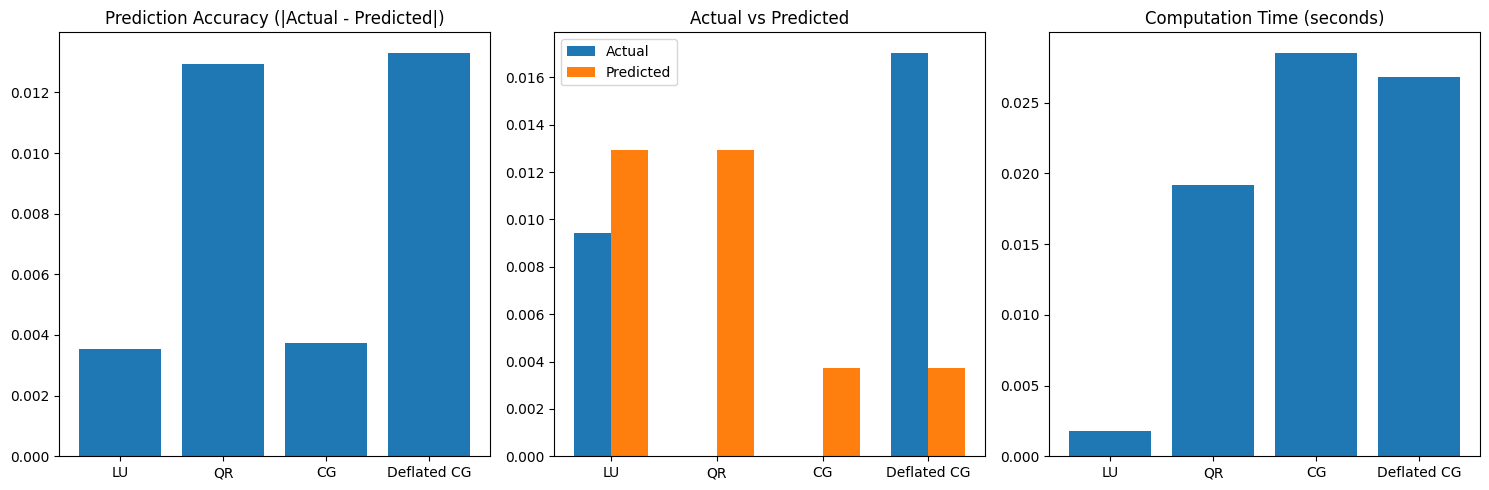

In [ ]:
# FROZENLAKE

import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
if not hasattr(np, 'float_'):
    np.float_ = np.float64

import gym
import time
from scipy import sparse
from scipy.sparse.linalg import spilu, cg, LinearOperator
from scipy.linalg import eigh
import matplotlib.pyplot as plt

try:
    from pyamg import ruge_stuben_solver
    PYAMG_AVAILABLE = True
except ImportError:
    PYAMG_AVAILABLE = False
    print("PyAMG not available. Skipping PyAMG solver.")

# --- Feature extraction for FrozenLake ---
def featurize_state_frozenlake(state, env):
    n_states = env.observation_space.n
    features = np.zeros(n_states)
    features[state] = 1.0
    return features

# --- LSTD for FrozenLake ---
def lstd_frozenlake(env, num_episodes, gamma, featurize):
    n_states = env.observation_space.n
    A = np.zeros((n_states, n_states))
    b = np.zeros(n_states)
    for _ in range(num_episodes):
        s = env.reset()
        phi = featurize(s, env)
        done = False
        while not done:
            a = env.action_space.sample()
            s_next, r, done, _ = env.step(a)
            phi_next = featurize(s_next, env) if not done else np.zeros(n_states)
            A += np.outer(phi, (phi - gamma * phi_next))
            b += r * phi
            phi = phi_next
            s = s_next
    return A, b

# --- Solvers ---
def solve_lu(A, b):
    return np.linalg.solve(A + 1e-5 * np.eye(A.shape[0]), b)

def solve_qr(A, b):
    return np.linalg.lstsq(A + 1e-5 * np.eye(A.shape[0]), b, rcond=None)[0]

def solve_cg(A, b):
    A_sym = 0.5 * (A + A.T) + 1e-5 * np.eye(A.shape[0])
    A_sparse = sparse.csc_matrix(A_sym)
    ilu = spilu(A_sparse)
    M = LinearOperator(A_sparse.shape, ilu.solve)
    theta, _ = cg(A_sparse, b, M=M)
    return theta

def get_bottom_k_eigenvectors(A, k):
    eigenvalues, eigenvectors = eigh(A)
    idx = np.argsort(np.abs(eigenvalues))
    return eigenvectors[:, idx[:k]]

def deflation_preconditioner(A, P):
    PT = P.T
    inv_PAP = np.linalg.inv(PT @ A @ P)
    return np.eye(A.shape[0]) - A @ P @ inv_PAP @ PT

def solve_cg_with_deflation_preconditioner(A, b, k=1):
    A_sym = 0.5 * (A + A.T) + 1e-5 * np.eye(A.shape[0])
    P = get_bottom_k_eigenvectors(A_sym, k)
    B_D = deflation_preconditioner(A_sym, P)
    M = LinearOperator(A.shape, matvec=lambda x: B_D @ x)
    theta, _ = cg(A_sym, b, M=M)
    return theta

def solve_pyamg(A, b):
    if not PYAMG_AVAILABLE:
        raise RuntimeError("PyAMG not installed")
    A_sparse = sparse.csr_matrix(A + 1e-5 * np.eye(A.shape[0]))
    ml = ruge_stuben_solver(A_sparse)
    return ml.solve(b, tol=1e-8, accel='cg')

# --- Evaluation ---
def evaluate_policy(env, theta, featurize, gamma, num_episodes=100):
    returns = []
    value_preds = []
    for _ in range(num_episodes):
        s = env.reset()
        value_preds.append(np.dot(featurize(s, env), theta))
        done = False
        total = 0.0
        t = 0
        while not done:
            a = env.action_space.sample()
            s, r, done, _ = env.step(a)
            total += (gamma ** t) * r
            t += 1
        returns.append(total)
    avg_return = np.mean(returns)
    avg_value_pred = np.mean(value_preds)
    print(f"Average actual return over {num_episodes} episodes: {avg_return:.5f}")
    print(f"Average predicted value at initial state: {avg_value_pred:.5f}")
    print(f"difference: {abs(avg_return - avg_value_pred):.5f}")
    return avg_return, avg_value_pred

# --- Main ---
def main_frozenlake():
    env = gym.make('FrozenLake-v1', is_slippery=True)
    gamma = 0.99
    num_data_episodes = 10000

    print("Collecting data with LSTD...")
    A, b = lstd_frozenlake(env, num_data_episodes, gamma, featurize_state_frozenlake)

    solvers = {}
    print("\nSolving using LU-decomposition...")
    start = time.time()
    theta_lu = solve_lu(A, b)
    solvers['LU'] = (theta_lu, time.time() - start)

    print("\nSolving using QR (least squares)...")
    start = time.time()
    theta_qr = solve_qr(A, b)
    solvers['QR'] = (theta_qr, time.time() - start)

    print("\nSolving using Conjugate Gradient with ILU preconditioner...")
    start = time.time()
    theta_cg = solve_cg(A, b)
    solvers['CG'] = (theta_cg, time.time() - start)

    print("\nSolving using Deflated Conjugate Gradient...")
    start = time.time()
    theta_deflated = solve_cg_with_deflation_preconditioner(A, b)
    solvers['Deflated CG'] = (theta_deflated, time.time() - start)

    if PYAMG_AVAILABLE:
        try:
            print("\nSolving using PyAMG...")
            start = time.time()
            theta_pyamg = solve_pyamg(A, b)
            solvers['PyAMG'] = (theta_pyamg, time.time() - start)
        except Exception as e:
            print(f"PyAMG solver failed: {str(e)}")

    # Evaluation
    errors, actuals, preds, times = [], [], [], []
    for name, (theta, t_taken) in solvers.items():
        print(f"\nEvaluation using {name} solution:")
        actual, predicted = evaluate_policy(env, theta, featurize_state_frozenlake, gamma)
        errors.append(abs(actual - predicted))
        actuals.append(actual)
        preds.append(predicted)
        times.append(t_taken)

    names = list(solvers.keys())
    x = np.arange(len(names))
    width = 0.35

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.bar(names, errors)
    plt.title('Prediction Accuracy (|Actual - Predicted|)')

    plt.subplot(1, 3, 2)
    plt.bar(x - width/2, actuals, width, label='Actual')
    plt.bar(x + width/2, preds, width, label='Predicted')
    plt.xticks(x, names)
    plt.legend()
    plt.title('Actual vs Predicted')

    plt.subplot(1, 3, 3)
    plt.bar(names, times)
    plt.title('Computation Time (seconds)')
    plt.tight_layout()
    plt.show()

    env.close()

if __name__ == '__main__':
    main_frozenlake()


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(



Solving with LU...

Solving with QR...

Solving with CG + ILU...

Solving with Deflated CG...

Solving with PyAMG...

Evaluating LU...
Average actual return: -524.91
Average predicted value: -399.39
Difference: 125.51

Evaluating QR...
Average actual return: -510.44
Average predicted value: -381.31
Difference: 129.13

Evaluating CG...
Average actual return: -506.33
Average predicted value: -332.15
Difference: 174.17

Evaluating Deflated CG...
Average actual return: -531.94
Average predicted value: -353.33
Difference: 178.61

Evaluating PyAMG...
Average actual return: -500.55
Average predicted value: -366.13
Difference: 134.42


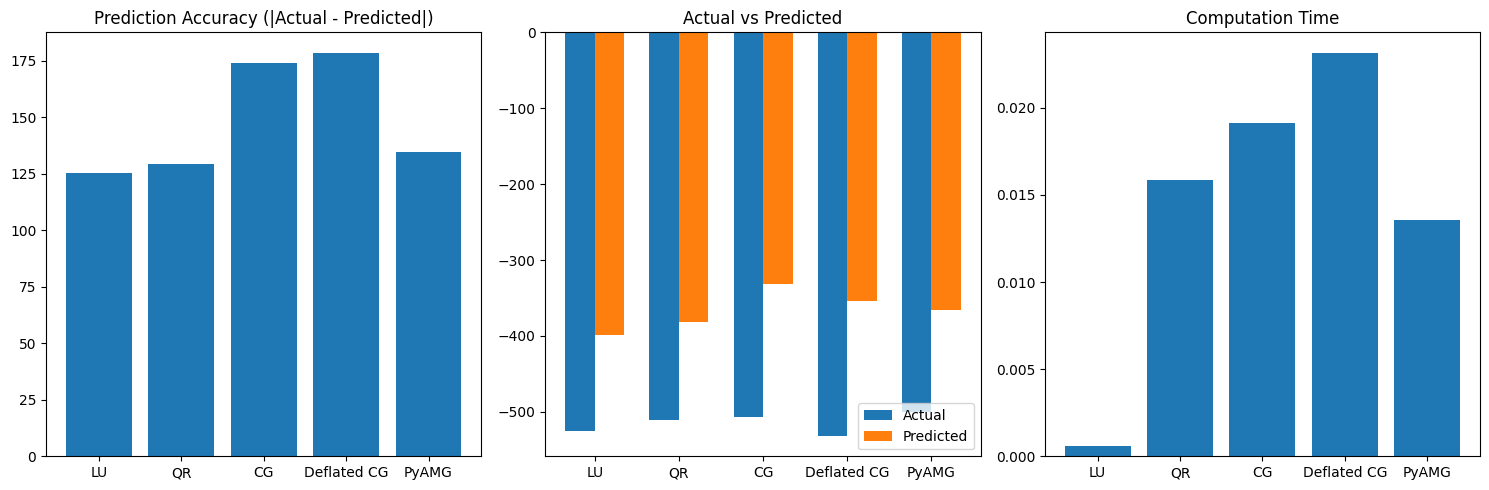

In [ ]:
# Full LSTD benchmark using Pendulum-v1 (no box2d dependency)
import numpy as np
import time
import gym
from scipy import sparse
from scipy.sparse.linalg import spilu, cg, LinearOperator
from scipy.linalg import eigh
import matplotlib.pyplot as plt

try:
    from pyamg import ruge_stuben_solver
    PYAMG_AVAILABLE = True
except ImportError:
    PYAMG_AVAILABLE = False

# NumPy 2.0 compatibility patches
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
if not hasattr(np, 'float_'):
    np.float_ = np.float64

# --- Feature extraction for Pendulum ---
def featurize_pendulum(state):
    """
    Pendulum state: [cos(theta), sin(theta), theta_dot]
    Feature vector includes:
    - Bias (1)
    - Original features (3)
    - Squared terms (3)
    - Cross term (theta * theta_dot)
    Total = 1 + 3 + 3 + 1 = 8
    """
    cos_t, sin_t, theta_dot = state
    theta = np.arctan2(sin_t, cos_t)
    features = np.array([
        1.0,
        cos_t, sin_t, theta_dot,
        cos_t**2, sin_t**2, theta_dot**2,
        theta * theta_dot
    ])
    return features

# --- LSTD Collection ---
def lstd(env, num_episodes, gamma, featurize):
    n_features = len(featurize(env.reset()))
    A = np.zeros((n_features, n_features))
    b = np.zeros(n_features)
    for _ in range(num_episodes):
        s = env.reset()
        phi = featurize(s)
        done = False
        while not done:
            a = env.action_space.sample()
            s_next, r, done, _ = env.step(a)
            phi_next = featurize(s_next) if not done else np.zeros(n_features)
            A += np.outer(phi, (phi - gamma * phi_next))
            b += r * phi
            phi = phi_next
            s = s_next
    return A, b

# --- Solvers ---
def solve_lu(A, b):
    return np.linalg.solve(A + 1e-5 * np.eye(A.shape[0]), b)

def solve_qr(A, b):
    return np.linalg.lstsq(A + 1e-5 * np.eye(A.shape[0]), b, rcond=None)[0]

def solve_cg(A, b):
    A_sym = 0.5 * (A + A.T) + 1e-5 * np.eye(A.shape[0])
    A_sparse = sparse.csc_matrix(A_sym)
    ilu = spilu(A_sparse)
    M = LinearOperator(A_sparse.shape, ilu.solve)
    theta, _ = cg(A_sparse, b, M=M)
    return theta

def get_bottom_k_eigenvectors(A, k):
    eigenvalues, eigenvectors = eigh(A)
    idx = np.argsort(np.abs(eigenvalues))
    return eigenvectors[:, idx[:k]]

def deflation_preconditioner(A, P):
    PT = P.T
    inv_PAP = np.linalg.inv(PT @ A @ P)
    return np.eye(A.shape[0]) - A @ P @ inv_PAP @ PT

def solve_cg_with_deflation_preconditioner(A, b, k=2):
    A_sym = 0.5 * (A + A.T) + 1e-5 * np.eye(A.shape[0])
    P = get_bottom_k_eigenvectors(A_sym, k)
    B_D = deflation_preconditioner(A_sym, P)
    M = LinearOperator(A.shape, matvec=lambda x: B_D @ x)
    theta, _ = cg(A_sym, b, M=M)
    return theta

def solve_pyamg(A, b):
    if not PYAMG_AVAILABLE:
        raise RuntimeError("PyAMG not installed")
    A_sparse = sparse.csr_matrix(A + 1e-5 * np.eye(A.shape[0]))
    ml = ruge_stuben_solver(A_sparse)
    return ml.solve(b, tol=1e-8, accel='cg')

# --- Evaluation ---
def evaluate_policy(env, theta, featurize, gamma, num_episodes=100):
    returns = []
    value_preds = []
    for _ in range(num_episodes):
        s = env.reset()
        value_preds.append(np.dot(featurize(s), theta))
        done = False
        total = 0.0
        t = 0
        while not done:
            a = env.action_space.sample()
            s, r, done, _ = env.step(a)
            total += (gamma ** t) * r
            t += 1
        returns.append(total)
    avg_return = np.mean(returns)
    avg_value_pred = np.mean(value_preds)
    print(f"Average actual return: {avg_return:.2f}")
    print(f"Average predicted value: {avg_value_pred:.2f}")
    print(f"Difference: {abs(avg_return - avg_value_pred):.2f}")
    return avg_return, avg_value_pred

# --- Main Routine ---
def main_pendulum():
    env = gym.make('Pendulum-v1')
    gamma = 0.99
    num_data_episodes = 1000

    print("Collecting data with LSTD...")
    A, b = lstd(env, num_data_episodes, gamma, featurize_pendulum)

    solvers = {}
    print("\nSolving with LU...")
    start = time.time()
    theta_lu = solve_lu(A, b)
    solvers['LU'] = (theta_lu, time.time() - start)

    print("\nSolving with QR...")
    start = time.time()
    theta_qr = solve_qr(A, b)
    solvers['QR'] = (theta_qr, time.time() - start)

    print("\nSolving with CG + ILU...")
    start = time.time()
    theta_cg = solve_cg(A, b)
    solvers['CG'] = (theta_cg, time.time() - start)

    print("\nSolving with Deflated CG...")
    start = time.time()
    theta_def = solve_cg_with_deflation_preconditioner(A, b)
    solvers['Deflated CG'] = (theta_def, time.time() - start)

    if PYAMG_AVAILABLE:
        try:
            print("\nSolving with PyAMG...")
            start = time.time()
            theta_pyamg = solve_pyamg(A, b)
            solvers['PyAMG'] = (theta_pyamg, time.time() - start)
        except Exception as e:
            print("PyAMG failed:", e)

    # Evaluation
    errors, actuals, preds, times = [], [], [], []
    for name, (theta, t_taken) in solvers.items():
        print(f"\nEvaluating {name}...")
        actual, pred = evaluate_policy(env, theta, featurize_pendulum, gamma)
        errors.append(abs(actual - pred))
        actuals.append(actual)
        preds.append(pred)
        times.append(t_taken)

    # Visualization
    names = list(solvers.keys())
    x = np.arange(len(names))
    width = 0.35

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.bar(names, errors)
    plt.title("Prediction Accuracy (|Actual - Predicted|)")

    plt.subplot(1, 3, 2)
    plt.bar(x - width/2, actuals, width, label="Actual")
    plt.bar(x + width/2, preds, width, label="Predicted")
    plt.title("Actual vs Predicted")
    plt.xticks(x, names)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.bar(names, times)
    plt.title("Computation Time")
    plt.tight_layout()
    plt.show()

    env.close()

main_pendulum()
